<a href="https://colab.research.google.com/github/IreneLedyaeva/CAP-5610/blob/master/HW3/problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing heatmaps of class activations

### Uploading the model obtained in problem 2

In [32]:
from google.colab import files

uploaded = files.upload()

Saving cats_and_dogs_pretrained.h5 to cats_and_dogs_pretrained.h5


### Uploading the images of cats and dogs

In [5]:
!wget https://cdn.royalcanin-weshare-online.io/d_o7IGYBIYfdNSoC2wgt/v1/bd29h-basset-hound-adult-in-black-and-white?raw=true -O basset_hound.jpg

!wget https://i.imgur.com/3qMPlcg.png?raw=true -O maine_coon.jpg
  
img_path1 = 'basset_hound.jpg'
img_path2 = 'maine_coon.jpg'

--2019-04-14 02:52:59--  https://cdn.royalcanin-weshare-online.io/d_o7IGYBIYfdNSoC2wgt/v1/bd29h-basset-hound-adult-in-black-and-white?raw=true
Resolving cdn.royalcanin-weshare-online.io (cdn.royalcanin-weshare-online.io)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to cdn.royalcanin-weshare-online.io (cdn.royalcanin-weshare-online.io)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2544249 (2.4M) [image/png]
Saving to: ‘basset_hound.jpg’

basset_hound.jpg    100%[===================>]   2.43M  11.8MB/s    in 0.2s    

2019-04-14 02:52:59 (11.8 MB/s) - ‘basset_hound.jpg’ saved [2544249/2544249]

--2019-04-14 02:53:00--  https://i.imgur.com/3qMPlcg.png?raw=true
Resolving i.imgur.com (i.imgur.com)... 151.101.248.193
Connecting to i.imgur.com (i.imgur.com)|151.101.248.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2023584 (1.9M) [image/png]
Saving to: ‘maine_coon.jpg’

maine_coon.jpg      100%[=====

### Getting the last convolutional layer

In [38]:
from keras.models import load_model

model = load_model('cats_and_dogs_pretrained.h5')
model.summary()

last_conv_layer = model.get_layer('vgg19')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Resizing the heatmap and processing the image

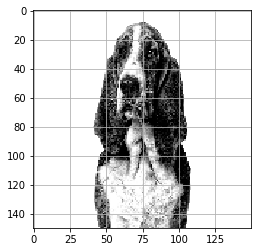

AttributeError: ignored

In [45]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)
  
def process_image(img_path, idx=0):
  
  img = image.load_img(img_path, target_size=(150, 150))
  
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  #print('Predicted:', decode_predictions(preds, top=2)[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  
  show_superimposed_image(img_path, heatmap)

process_image(img_path1)